# Flights Delay Prediction ✈️ - Data Pre-Processing

This notebook focus on the pre-processing of data.

In [ ]:
!pip install category_encoders

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import preprocess as pp
import category_encoders as ce
# ML
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
# Options
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
def rearrange_date(df):
    """
    Merges YEAR, MONTH, DAY and puts it into a datetime object.
    Creates DAY_OF_WEEK based on date.
    """
    # Create a Date Time Variable - YEAR-MONTH-DAY all in the same field - train
    df = df.astype({'YEAR': 'str', 'MONTH': 'str', 'DAY': 'str'})
    df["DATE"] = df["DAY"].str.cat(df[['MONTH', 'YEAR']], sep='-')
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()
    df['MONTH'] = df['DATE'].dt.month_name()
    df.drop(columns=['YEAR', 'DAY'], inplace=True)
    return df


def departure_delay(day, scheduled_departure, departure, arrival_delay=None):
    '''
    Calculate the departure delay.
    Assumption: the delay is always positive unless the negative delay is less than 90 minutes.

    Input:
    date - date of the schedule departure. - datetime
    scheduled_departure - time (hhmm) for the scheduled departure. - int64
    departure - actual time (hhmm) for the departure. - float64
    '''
    # Transform to datetime objects
    scheduled_departure = "{0:04d}".format(int(scheduled_departure))
    scheduled_departure = day + datetime.timedelta(hours=int(scheduled_departure[0:2]),
                                                   minutes=int(scheduled_departure[2:4]))
    departure = "{0:04d}".format(int(departure))
    departure = datetime.timedelta(hours=int(departure[0:2]), minutes=int(departure[2:4]))

    # Create array with possible intervals
    previous_day = day - datetime.timedelta(days=1)
    previous_day_departure = previous_day + departure
    day_departure = day + departure
    next_day = day + datetime.timedelta(days=1)
    next_day_departure = next_day + departure
    time_differences = np.array([(previous_day_departure - scheduled_departure).total_seconds(),
                                 (day_departure - scheduled_departure).total_seconds(),
                                 (next_day_departure - scheduled_departure).total_seconds()]) / 60
    time_differences = time_differences[time_differences > -90]
    min_index = np.argmin(np.abs(time_differences))
    if arrival_delay:
        arrival_departure_difference = np.abs(arrival_delay - time_differences)
        min_index = np.argmin(arrival_departure_difference)
    # Get minimum interval
    return time_differences[min_index]


def one_hot_encode_main(df_train, df_test):
    # Create Encoder Object
    encoder = ce.BinaryEncoder(cols=['MONTH', 'DAY_OF_WEEK', 'AIRLINE', 'SCHEDULED_DEPARTURE'], return_df=True)
    # Encode Train Set
    df_train["SCHEDULED_DEPARTURE"] = df_train.apply(lambda row: "{0:04d}".format(int(row["SCHEDULED_DEPARTURE"])), axis=1)
    df_train = encoder.fit_transform(df_train)
    # Encode Test Set
    df_test["SCHEDULED_DEPARTURE"] = df_test.apply(lambda row: "{0:04d}".format(int(row["SCHEDULED_DEPARTURE"])),axis=1)
    df_test = encoder.fit_transform(df_test)
    #df = pd.get_dummies(df, columns=['MONTH'], prefix='', prefix_sep='')
    #df = pd.get_dummies(df, columns=['DAY_OF_WEEK'], prefix='', prefix_sep='')
    #df = pd.get_dummies(df, columns=['AIRLINE'], prefix='AIRLINE', prefix_sep='_')
    return df_train, df_test


def one_hot_encode_airports(df_train, df_test):
    # Create object for binary encoding
    encoder = ce.BinaryEncoder(cols=['AIRPORTS'], return_df=True)
    # Create target encoding object
    encoder_target = ce.TargetEncoder(cols=['AIRPORTS'], return_df=True)
    # Encode Train Set
    df_train['AIRPORTS'] = df_train['ORIGIN_AIRPORT'].str.cat(df_train['DESTINATION_AIRPORT'], sep="-")
    df_train['AIRPORT_TargetEncoding'] = encoder_target.fit_transform(df_train['AIRPORTS'], df_train['DEPARTURE_DELAY'])
    df_train = encoder.fit_transform(df_train)
    # Encode Test Set
    df_test['AIRPORTS'] = df_test['ORIGIN_AIRPORT'].str.cat(df_test['DESTINATION_AIRPORT'], sep="-")
    df_test['AIRPORT_TargetEncoding'] = encoder_target.fit_transform(df_test['AIRPORTS'], df_test['DEPARTURE_DELAY'])
    df_test = encoder.fit_transform(df_test)
    return df_train, df_test


def create_output(predictions):
    """
    Function that creates output csv submission file. Returns the submission dataframe.
    Input:
    - predictions: an array with shape (n_predictions, 1) with the ARRIVAL_DELAY outputs (ordered).
    Return:
    - submission: dataframe with id and ARRIVAL_DELAY fields.
    """
    submission = pd.DataFrame(data={"id": np.arange(len(predictions)),
                                    "ARRIVAL_DELAY": np.reshape(predictions,(len(predictions)))})
    submission.to_csv("data/submission.csv", index=False)
    return submission


In [ ]:
# Read Data
# Original
airlines_raw = pd.read_csv("data/airlines.csv")
airports_raw = pd.read_csv("data/airports.csv")
flights_train_raw = pd.read_csv("data/flights_train.csv").iloc[:500000] # Just the first 500k (train) rows so it is not to heavy
flights_test_raw = pd.read_csv("data/flights_test.csv").iloc[:5000] # Just the first 5k (test) rows so it is not to heavy
# Copies (work on the copies)
airlines = airlines_raw.copy()
airports = airports_raw.copy()
flights_train = flights_train_raw.copy()
flights_test = flights_test_raw.copy()

# Drop columns that don't add information
flights_train.drop(columns=["WHEELS_OFF", "FLIGHT_NUMBER", "TAIL_NUMBER"], inplace=True)
flights_test.drop(columns=["WHEELS_OFF", "FLIGHT_NUMBER", "TAIL_NUMBER"], inplace=True)

# Create Date with Datetime obj
flights_train = rearrange_date(flights_train)
flights_test = rearrange_date(flights_test)

# Calculate Departure Delay
flights_train["DEPARTURE_DELAY"] = flights_train.apply(lambda row: departure_delay(row["DATE"],
                                                                                    row["SCHEDULED_DEPARTURE"],
                                                                                    row["DEPARTURE_TIME"],
                                                                                    row["ARRIVAL_DELAY"]), axis=1)
flights_test["DEPARTURE_DELAY"] = flights_test.apply(lambda row: departure_delay(row["DATE"],
                                                                                    row["SCHEDULED_DEPARTURE"],
                                                                                    row["DEPARTURE_TIME"]), axis=1)

# OneHot Encode Labels
flights_train, flights_test = one_hot_encode_main(flights_train, flights_test)
# Origins and Destinations
flights_train, flights_test = one_hot_encode_airports(flights_train, flights_test)

print("Done")
# Save pre-processed data
flights_train.to_csv("data/pp_flights_train.csv", index=False)
flights_test.to_csv("data/pp_flights_test.csv", index=False)

Done


In [ ]:
#flights_train[(flights_train["ARRIVAL_DELAY"] > 1000) & (flights_train["DEPARTURE_DELAY"] < 600)]
#flights_train.drop(flights_train[(flights_train["ARRIVAL_DELAY"] > 1000) & (flights_train["DEPARTURE_DELAY"] < 600)].index, inplace=True)
# Fit a Simple Linear Model
# Split Data
X, Y = flights_train['DEPARTURE_DELAY'].to_numpy().reshape(-1,1) , flights_train['ARRIVAL_DELAY']
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.05, random_state=42)
X_test = flights_test['DEPARTURE_DELAY'].to_numpy().reshape(-1,1)
lm = LinearRegression().fit(X_train,Y_train)
# Check Validation Metrics
predictions_val = lm.predict(X_val)
print("MSE =", metrics.mean_squared_error(predictions_val, Y_val))
# Build prediction for Test Set
predictions_test = lm.predict(X_test)

MSE = 180.08007297083822


In [ ]:
# Regression with Polynomial Features
# Select model hyperparameters (here, we will use a polynomial, degree 2, basis function)
polymodel = make_pipeline(PolynomialFeatures(3), LinearRegression(fit_intercept=True))
pm = polymodel.fit(X_train, Y_train)
predictions_val = pm.predict(X_val)
# Check Validation Metrics
predictions_val = pm.predict(X_val)
print("MSE =", metrics.mean_squared_error(predictions_val, Y_val))
# Build prediction for Test Set
predictions_test = lm.predict(X_test)

MSE = 180.05776452276942


In [ ]:
submission = pp.create_output(predictions_test)

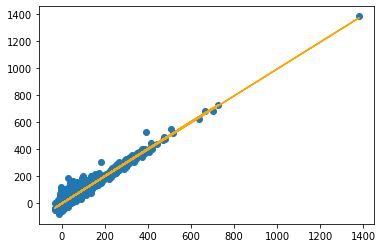

In [ ]:
# Plot model regression line on top of actual delays - Baseline
import matplotlib.pyplot as plt
plt.scatter(X_val.reshape(-1), Y_val.to_numpy())
plt.plot(X_val.reshape(-1), predictions_val.reshape(-1), color='orange')
plt.show()

In [ ]:
sns.pairplot(flights_train.loc[:,"AIRLINE":].sample(100))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3bc7d17b-1023-4c90-8547-80a861833ae0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>